<a href="https://colab.research.google.com/github/a-coding-Kat/dlbs-mini-challenge-hs26/blob/main/01_exploratory_image_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Exploratory Image Analysis

We want to check the image characteristics that YOLOv8 uses in its training process.


Low-level features are used to establish the basic outline of an object against the background:
- edges, corners, lines, color gradients and textures.     
It uses these features

Mid-level features/patterns are used to establish the part of an object, contributing to the Objectness Scores. THese are:   
- arcs, circles, repetitive textures and components that represent a part of the object (beard, hat, belt).    
These

High-level features are used for classification to differentiate between similar objects:   
- a humanoid form with a unique red-white color combination, gestalt recognition.


Since we train YOLO on Santas:

 - low-level: red/white edges   
 - mid-level: beard texture, hat shape   
 - high-level: human-like figure × red outfit × holiday context



Why YOLOv8? It strikes the best balance of:

High accuracy for complex features (won't confuse Santa with similar-looking humans/elves)
Fast inference for real-time detection
Easy fine-tuning on custom Santa datasets
Strong feature extraction to distinguish Santa's unique characteristics (hat + beard + red suit combo, belly shape, gift bag, etc.)

YOLOv11 (released 2024) might be even better for cutting-edge performance.

In [ ]:
import os
import glob
import random
import cv2
import matplotlib.pyplot as plt

In [11]:
# Add images
!pip install roboflow

# Access Roboflow API key from Colab secrets
from google.colab import userdata
ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')

# Roboflow initialization
from roboflow import Roboflow
rf = Roboflow(api_key=ROBOFLOW_API_KEY)

# Dowload dataset
project = rf.workspace("dlbs-xi5zk").project("santa-qqpxm")
version = project.version(3)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...


In [7]:
!ls -F

sample_data/  Santa-3/


In [10]:
!ls -F Santa-3

data.yaml  README.dataset.txt  README.roboflow.txt  test/  train/  valid/


In [12]:
DATASET_PATH = "Santa-3"
NUM_IMAGES_TO_VISUALIZE = 10

In [15]:
def visualize_images(image_paths, split_name):
    if not image_paths:
        print(f"No images found in the '{split_name}' split.")
        return

    # Define the number of images you want to visualize (you can adjust this)
    NUM_IMAGES_TO_VISUALIZE = 10

    # Randomly select images from the list
    sample_images = random.sample(image_paths, min(NUM_IMAGES_TO_VISUALIZE, len(image_paths)))

    # Calculate the grid size for plotting
    num_plots = len(sample_images)
    cols = 5
    rows = (num_plots + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))
    axes = axes.flatten()

    fig.suptitle(f"Random {num_plots} Images from {split_name} Split", fontsize=16)

    for i, img_path in enumerate(sample_images):
        # 1. Read the image and convert to RGB
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # 2. Get the dimensions (OpenCV returns height, width, channels)
        height, width, _ = img.shape

        # 3. Extract the image ID number
        filename = os.path.basename(img_path)

        # Split the filename by the first underscore and take the first part ('409')
        # This handles filenames like '409_Santa.jpg...'
        try:
            image_id = filename.split('_')[0]
        except IndexError:
            # Fallback if the file doesn't have an underscore
            image_id = filename.split('.')[0]

        # 4. Create the formatted title
        title = f"Image {image_id}\n({width}x{height} px)"

        # Display the image
        axes[i].imshow(img_rgb)
        axes[i].set_title(title, fontsize=10) # Set the new, formatted title
        axes[i].axis('off')

    # Turn off any unused subplots
    for j in range(num_plots, rows * cols):
        axes[j].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


Found 555 total images in the train split.


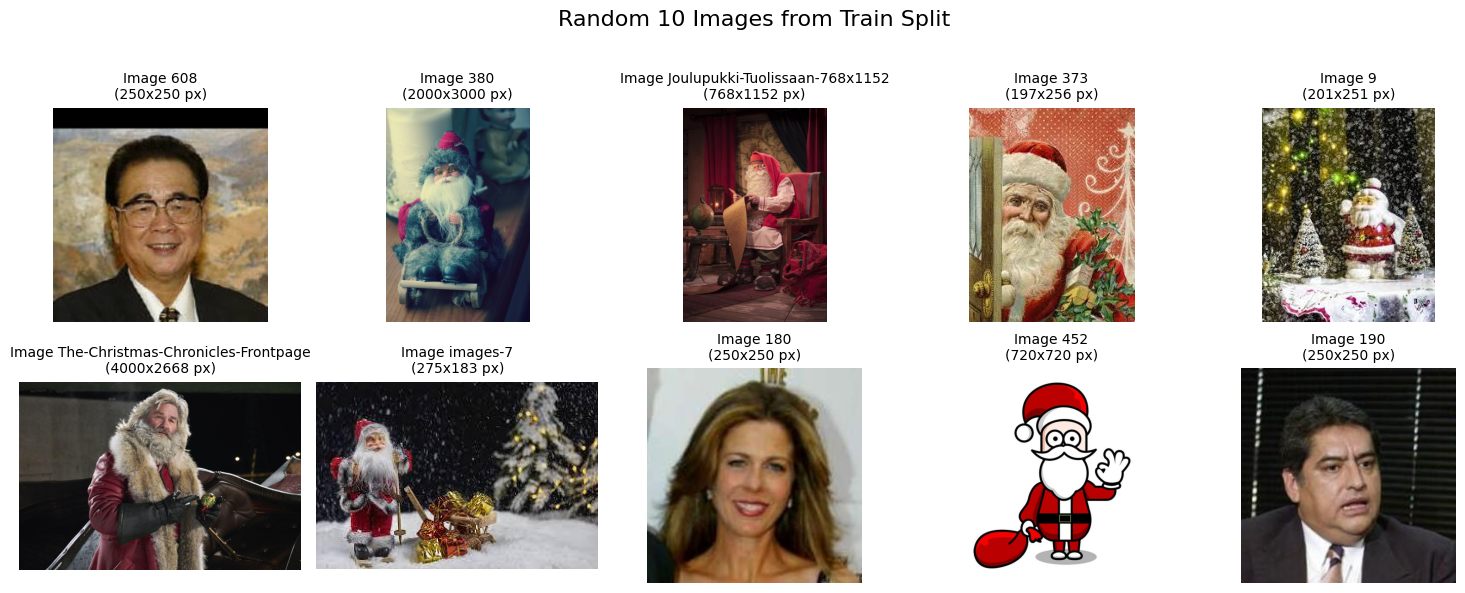


Found 85 total images in the test split.


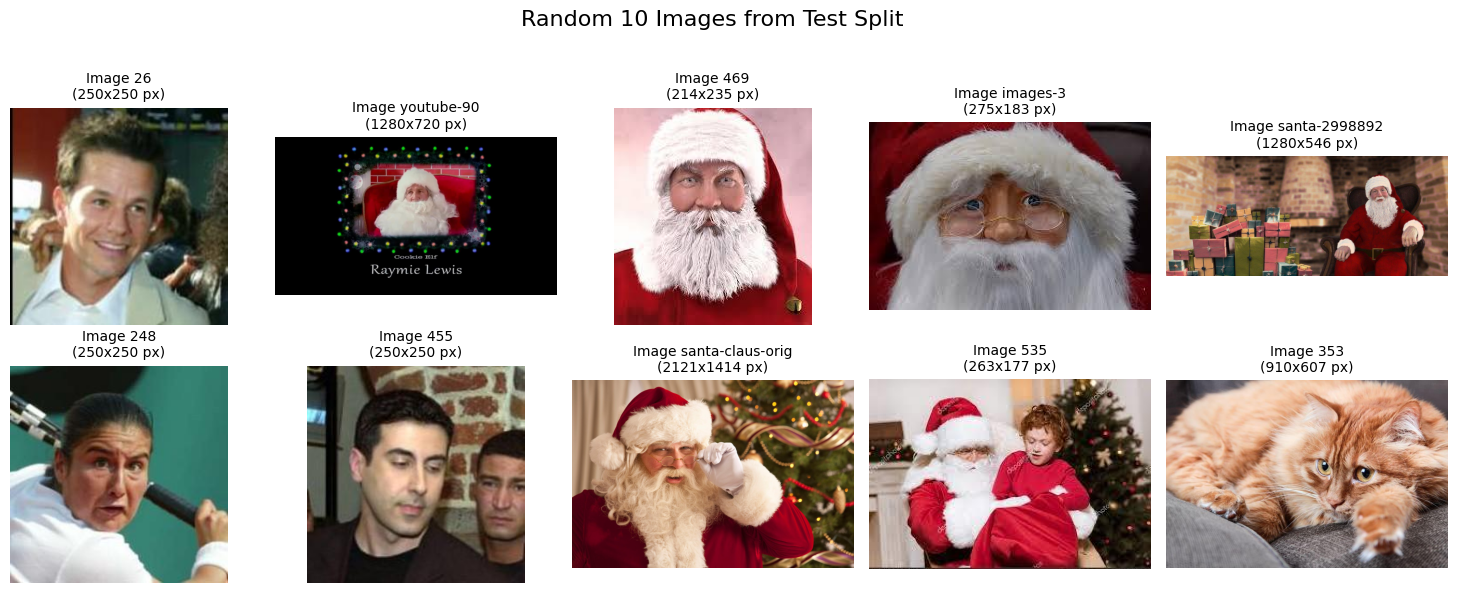


Found 85 total images in the valid split.


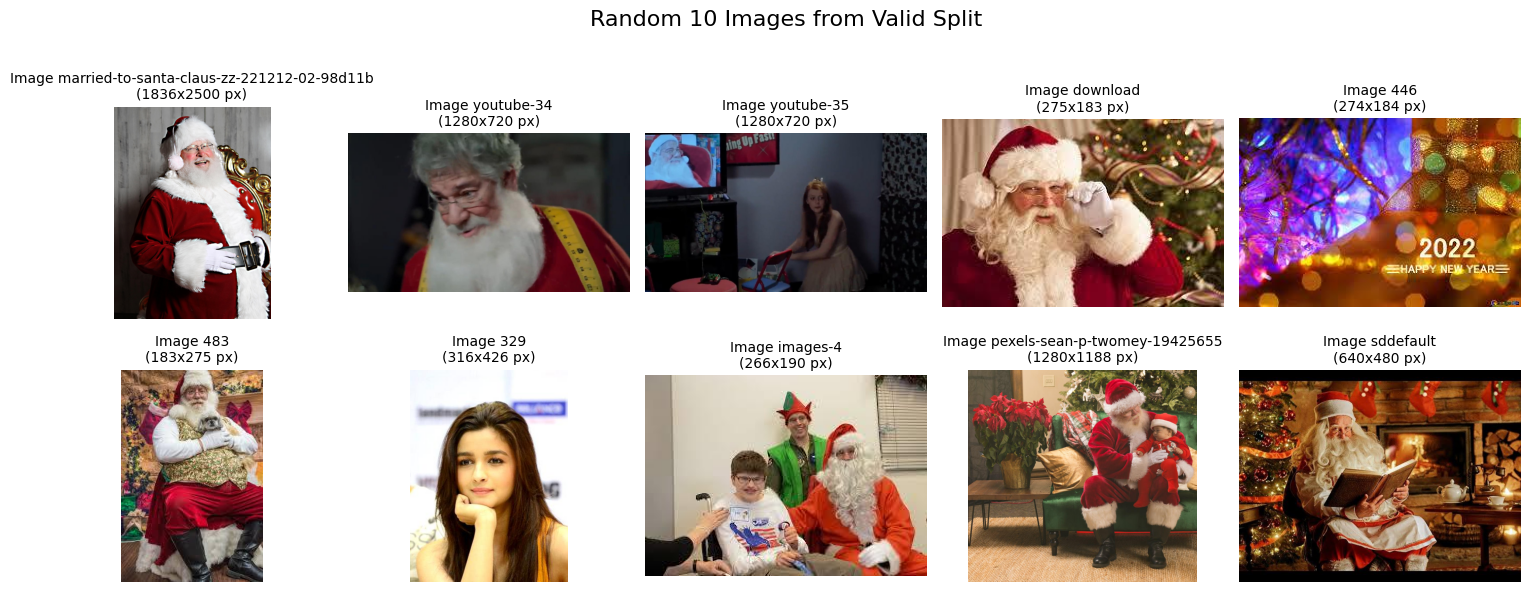

In [16]:
# List of splits to check
splits = ["train", "test", "valid"]

for split in splits:
    # Construct the search pattern: e.g., 'santa-qqpxm-3/train/images/*.jpg'
    search_path = os.path.join(DATASET_PATH, split, "images", "*.jpg")

    # Find all image paths matching the pattern
    all_image_paths = glob.glob(search_path)

    # If no JPGs were found, try PNGs
    if not all_image_paths:
        search_path_png = os.path.join(DATASET_PATH, split, "images", "*.png")
        all_image_paths = glob.glob(search_path_png)

    print(f"\nFound {len(all_image_paths)} total images in the {split} split.")

    # Visualize the random sample
    visualize_images(all_image_paths, split.capitalize())

# Comment on the images, if they are a good example for variety to train a robust model.

Total labeled objects found: 330
Number of 'Santa' objects (Class 0): 330
Average objects per image: 0.59


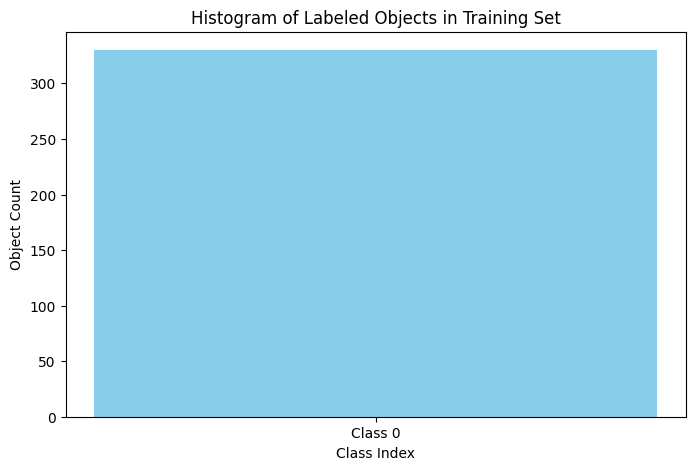


--- Interpretation of 'Santa vs. Not Santa' Balance ---
Since only one class (Santa) is labeled, the 'Santa vs. Not Santa' balance is about the ratio of **pixels covered by bounding boxes** compared to the **total background pixels**.
In most object detection tasks, the background (Not Santa) is massive compared to the objects (Santa), leading to an inherent class imbalance that YOLO handles via its loss functions (like DFL).


In [17]:
# Label Histogram and Class Balance: how much positive examples of Santa class do we have in the training dataset?
# Path to the YOLOv8 label files
train_labels_path = os.path.join(DATASET_PATH, "train", "labels", "*.txt")
all_label_files = glob.glob(train_labels_path)

# Dictionary to store class counts
class_counts = {}
total_objects = 0

for label_file in all_label_files:
    with open(label_file, 'r') as f:
        lines = f.readlines()

        for line in lines:
            # The first character of the line is the class index
            try:
                class_index = int(line.strip().split(' ')[0])
                class_counts[class_index] = class_counts.get(class_index, 0) + 1
                total_objects += 1
            except (ValueError, IndexError):
                # Skip any malformed lines
                continue

# Assuming your Santa class is index 0 (typical for single-class YOLO projects)
santa_count = class_counts.get(0, 0)
not_santa_count = total_objects - santa_count # Should be 0 if only Santa is labeled

# For YOLO object detection, the concept of "Santa vs. Not Santa" is addressed in two parts:
# 1. Class Balance (labeled objects): How many Santa objects vs. other object classes?
# 2. Background Balance (image regions): How much of the image is background (Not Santa)?

print(f"Total labeled objects found: {total_objects}")
print(f"Number of 'Santa' objects (Class 0): {santa_count}")
if total_objects > 0:
    print(f"Average objects per image: {total_objects / len(all_label_files):.2f}")
else:
    print("No annotations found. Please check label file paths.")

# --- Visualization ---
if class_counts:
    labels = [f"Class {i}" for i in class_counts.keys()]
    counts = list(class_counts.values())

    plt.figure(figsize=(8, 5))
    plt.bar(labels, counts, color='skyblue')
    plt.title("Histogram of Labeled Objects in Training Set")
    plt.xlabel("Class Index")
    plt.ylabel("Object Count")
    plt.show()

# --- Balance Interpretation ---
print("\n--- Interpretation of 'Santa vs. Not Santa' Balance ---")
if len(class_counts) > 1:
    print(f"The labeled objects are {len(class_counts)}-way balanced/unbalanced.")
else:
    # If only one class (Santa) is present, the balance is about object count vs. background.
    print(f"Since only one class (Santa) is labeled, the 'Santa vs. Not Santa' balance is about the ratio of **pixels covered by bounding boxes** compared to the **total background pixels**.")
    print("In most object detection tasks, the background (Not Santa) is massive compared to the objects (Santa), leading to an inherent class imbalance that YOLO handles via its loss functions (like DFL).")

Processing image: youtube-4_jpg.rf.921b823186db5865d7b72c09a64c6290.jpg


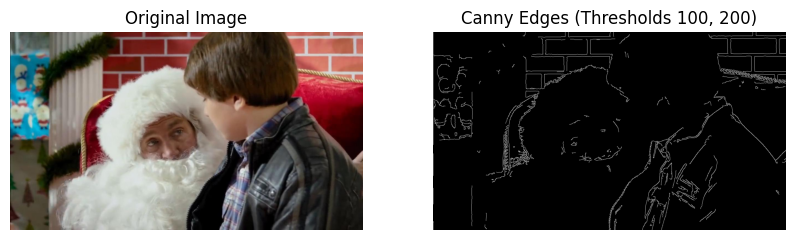

In [19]:
# Do the images have clear edges?
# Select a random image

# Find all images in the train split
train_images_path = os.path.join(DATASET_PATH, "train", "images", "*.jpg")
all_train_images = glob.glob(train_images_path)

sample_img_path = random.choice(all_train_images)
print(f"Processing image: {os.path.basename(sample_img_path)}")

# Load the image
img = cv2.imread(sample_img_path)

# Canny Edge Detection (Thresholds 100 and 200 are common starting points)
# The Canny operator is essential for low-level feature extraction in vision tasks.
edges = cv2.Canny(img, 100, 200)

# Convert the original image from BGR (OpenCV) to RGB (Matplotlib)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Visualize the results
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Original Image
axes[0].imshow(img_rgb)
axes[0].set_title("Original Image")
axes[0].axis('off')

# Edge Map
# The 'gray' colormap is used because Canny returns a grayscale (binary) image.
axes[1].imshow(edges, cmap='gray')
axes[1].set_title("Canny Edges (Thresholds 100, 200)")
axes[1].axis('off')

plt.show()

Processing and visualizing 10 images...


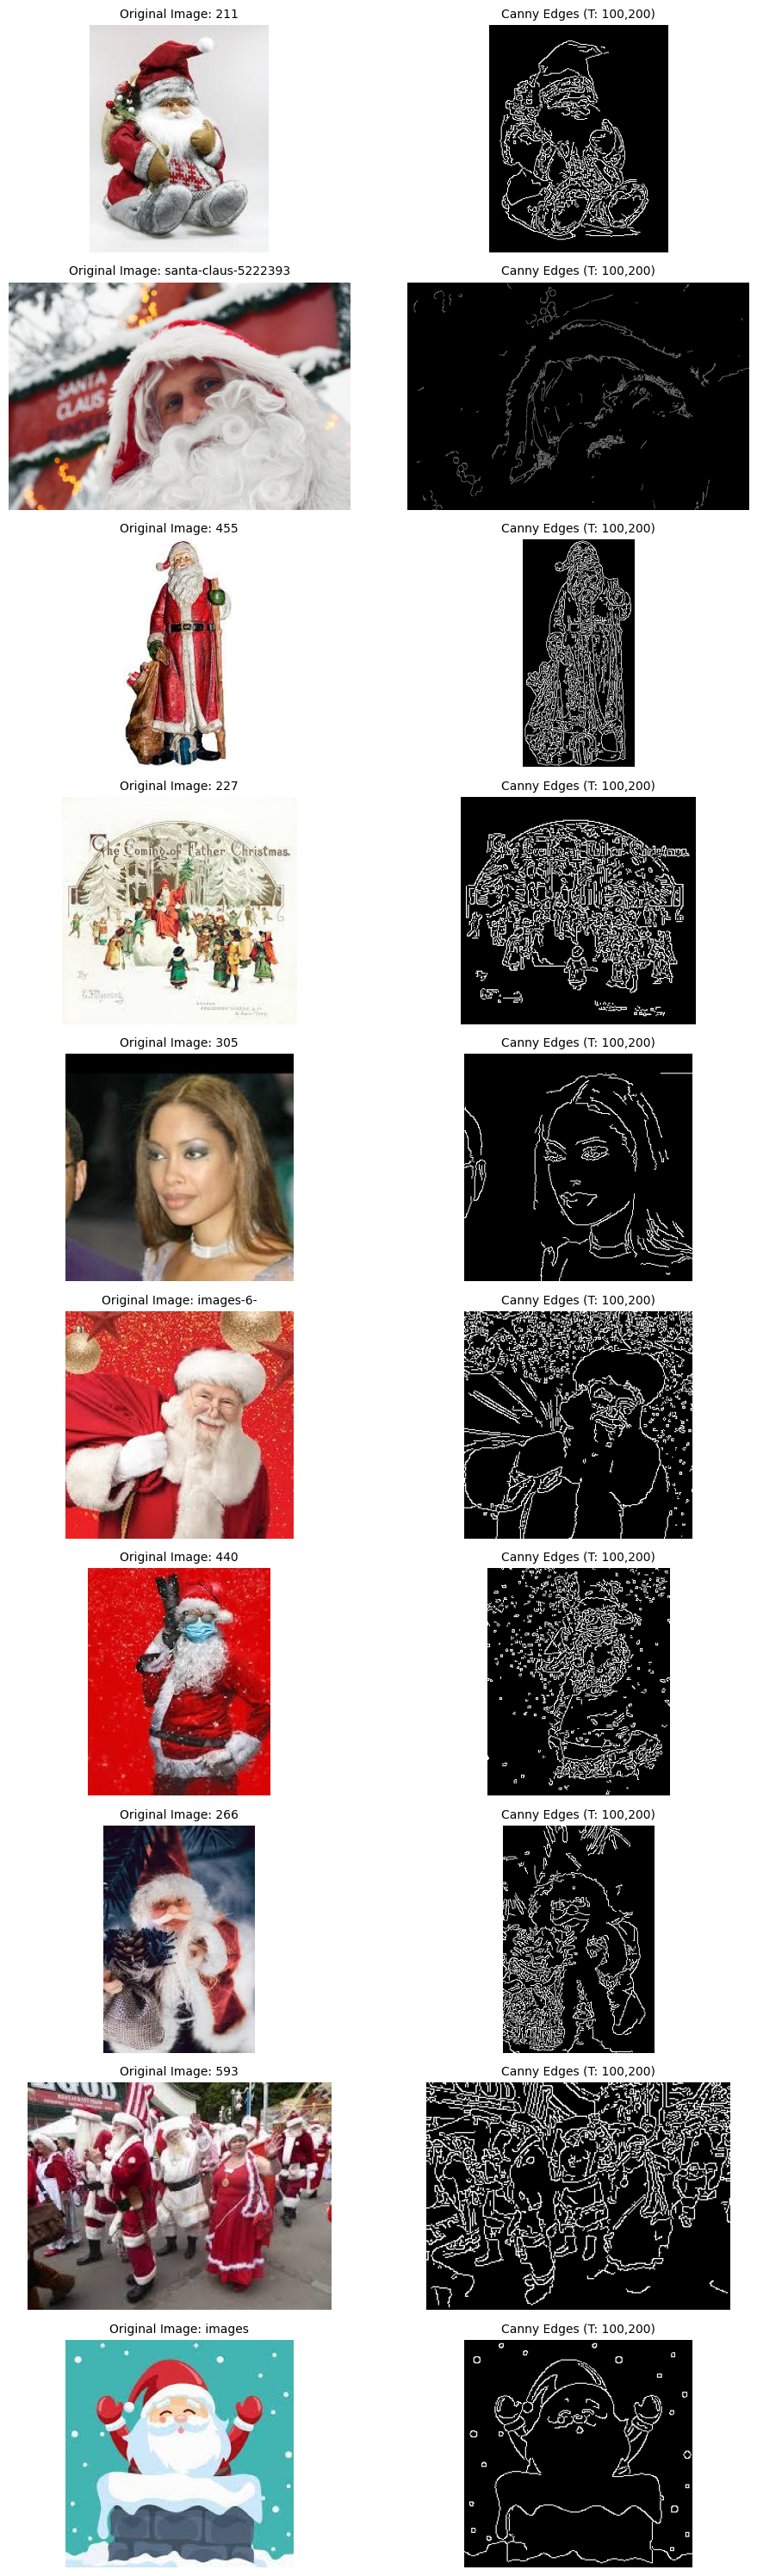

In [20]:
NUM_SAMPLES = 10
CANNY_THRESHOLD_1 = 100 # weakest edges
CANNY_THRESHOLD_2 = 200 # strongest edges

# --- File Selection ---
train_images_path = os.path.join(DATASET_PATH, "train", "images", "*.jpg")
all_train_images = glob.glob(train_images_path)

if not all_train_images:
    print(f"Error: No JPEG images found in {os.path.join(DATASET_PATH, 'train', 'images')}. Check your path or file type.")
    # Attempt to check for PNGs as a fallback
    train_images_path = os.path.join(DATASET_PATH, "train", "images", "*.png")
    all_train_images = glob.glob(train_images_path)
    if not all_train_images:
        print("Error: No PNG images found either. Exiting.")
        # Stop execution if no images are found
        exit()

# Randomly select 10 unique images (or fewer if less than 10 are available)
sample_image_paths = random.sample(all_train_images, min(NUM_SAMPLES, len(all_train_images)))

print(f"Processing and visualizing {len(sample_image_paths)} images...")

# --- Looping and Visualization ---

# Set up a large figure to hold all the plots
# We'll use 5 rows and 4 columns (2 columns per image: Original + Edges)
rows = len(sample_image_paths)
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 3 * rows))

# Handle case where only 1 image is selected
if rows == 1:
    axes = [axes] # Wrap axes in a list if only one row

# Loop through each selected image
for i, img_path in enumerate(sample_image_paths):
    filename = os.path.basename(img_path)

    # 1. Load the image
    img = cv2.imread(img_path)

    # Check if the image loaded successfully
    if img is None:
        print(f"Warning: Could not load image {filename}. Skipping.")
        continue

    # 2. Convert to RGB for Matplotlib and Grayscale for Canny
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Canny Edge Detection requires grayscale input
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 3. Apply Canny Edge Detection
    edges = cv2.Canny(img_gray, CANNY_THRESHOLD_1, CANNY_THRESHOLD_2)

    # 4. Extract Image ID (for clean title)
    try:
        image_id = filename.split('_')[0]
    except IndexError:
        image_id = filename.split('.')[0]

    # --- Plotting ---

    # Plot Original Image
    ax_orig = axes[i][0]
    ax_orig.imshow(img_rgb)
    ax_orig.set_title(f"Original Image: {image_id}", fontsize=10)
    ax_orig.axis('off')

    # Plot Edge Map
    ax_edges = axes[i][1]
    # Use 'gray' colormap for the edge map
    ax_edges.imshow(edges, cmap='gray')
    ax_edges.set_title(f"Canny Edges (T: {CANNY_THRESHOLD_1},{CANNY_THRESHOLD_2})", fontsize=10)
    ax_edges.axis('off')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

For Santa Claus images, we want thresholds that are high enough to capture the strong boundaries of the red suit, hat, and belt (the mid-level features) but low enough to capture the edges of the white beard and fur trim without picking up excessive background noise.